In [2]:
from solver import Solver
from model import Net
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

In [3]:
def get_train_range(dim):
    if dim == 2:
        train_range = range(1, 51, 1)
    elif dim == 3:
        train_range = range(10, 501, 10)
    elif dim == 5:
        train_range = range(50, 5001, 50)
    elif dim == 10:
        train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
    return train_range

In [4]:
def get_checkpoint_dir(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)

In [5]:
loss_fns = ['error', 'det', 'norm', 'detnorm']

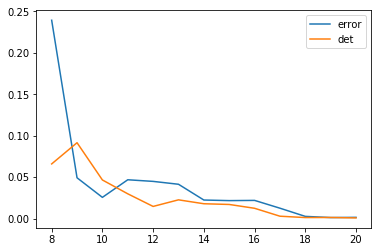

In [56]:
# Plot final test loss
dim = 2
train_range = get_train_range(dim)
for lossfn in ['error', 'det']:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 7, 20
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

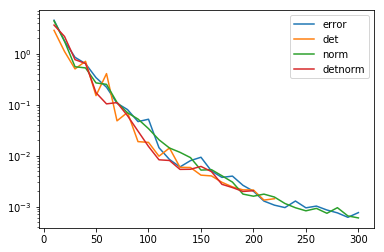

In [39]:
# Plot final test loss
dim = 3
train_range = get_train_range(dim)
for lossfn in loss_fns:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 30
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
plt.yscale('log')
plt.show()

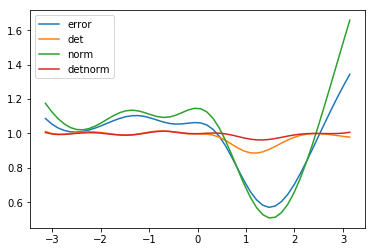

In [37]:
# Plot determinant
dim = 2
n_train = 10
for lossfn in loss_fns:
    dets = []
    model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
    solver = Solver(model)
    filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
    if os.path.exists(filepath):
        solver.load_checkpoint(filepath)
        alphas = np.linspace(-math.pi, math.pi)
        matrices = solver.model(torch.FloatTensor([[a] for a in alphas]))
        dets = [torch.det(mat) for mat in matrices]
        plt.plot(alphas, dets, label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

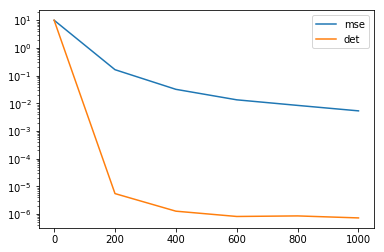

In [47]:
path = 'checkpoints/checkpoints-detweight/checkpoints_detweight-1e-05_dim-2_ntrain-11_seed-1683/final.pkl'
# Plot train loss
dim = 2
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
solver.load_checkpoint(path)
for key in solver.hist["individual_train_losses"]:
    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key)
plt.legend()
plt.yscale('log')
plt.show()

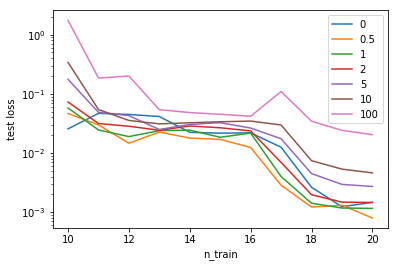

In [42]:
# Plot final test loss
dim = 2
train_range = range(10, 21, 1)
for det_weight in [0, 0.5, 1, 2, 5, 10, 100]:# [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100]:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = 'checkpoints/checkpoints-detweight/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(det_weight, dim, n_train, 1683)
        if det_weight == 0.5:
            filepath = 'checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/final.pkl'.format(dim, n_train, 'det', 1683)
        if det_weight == 0:
            filepath = 'checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/final.pkl'.format(dim, n_train, 'error', 1683)
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 20
    plt.plot(ntrains, test_loss, label=det_weight)
plt.legend()
plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()

n_train = 15, det_weight = 0.01
511.5700979232788


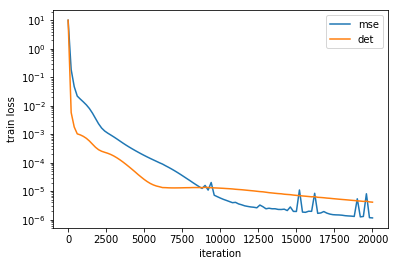

In [23]:
dim = 2
n_train = 15
det_weight = 1e-2
print("n_train = {}, det_weight = {}".format(n_train, det_weight))
path = 'checkpoints/checkpoints-detweight/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(det_weight, dim, n_train, 1683)
# Plot train loss
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
solver.load_checkpoint(path)
for key in solver.hist["individual_train_losses"]:
    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key)
plt.legend()
plt.yscale('log')
plt.ylabel("train loss")
plt.xlabel("iteration")
plt.show()

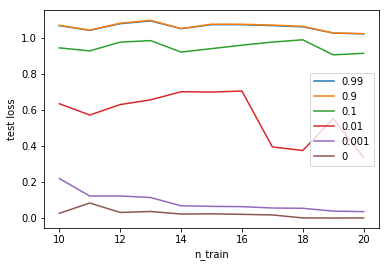

In [50]:
# Plot final test loss
dim = 2
train_range = range(10, 21, 1)
train_seed = 1683
for weight_decay in [0.99, 0.9, 0.1, 0.01, 0.001, 0]:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'checkpoints_weight_decay_mse/'
        checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_weightdecay-{}_seed-{}'.format(dim, n_train, weight_decay,
                                                                                      train_seed)
        filepath = checkpoint_dir + 'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    plt.plot(ntrains, test_loss, label=weight_decay)
plt.legend()
# plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()